In [25]:
import torch
from torch.utils import data
from torch import optim
from torch.autograd import Variable
from data import VOCDetection, AnnotationTransform, detection_collate
from augmentations import SSDAugmentation
from ssd import build_ssd
from layers.modules import MultiBoxLoss
from tqdm import tqdm

In [26]:
ds = VOCDetection("WIDER",transform=SSDAugmentation(), 
                  target_transform=AnnotationTransform())
net = build_ssd("test", size=300, num_classes=2)

In [27]:
state_dict = torch.load("./weights/epoch_9.pth")


In [28]:
net.load_state_dict(state_dict, strict=True)

In [29]:
img, label = ds[0]

In [7]:
label

array([[0.4375    , 0.23754513, 0.55664062, 0.34512635, 0.        ]])

In [9]:
net(Variable(img.unsqueeze(0)))

(Variable containing:
 ( 0  ,.,.) = 
   1.6290e+00  1.8656e+00 -1.1091e+01 -9.9209e+00
   1.5606e-01 -3.7185e-01 -6.5864e-01 -5.6696e-01
   2.4309e+00  4.1476e-01 -1.1062e+01 -7.7801e+00
                        ⋮                        
  -4.3178e-01  2.3841e-01 -2.0109e+00 -4.8844e-01
  -6.7236e-01 -1.0437e-01 -2.4014e+00  1.9202e+00
  -4.0204e-01  4.9078e-01  4.8589e-01 -1.2783e+00
 [torch.FloatTensor of size 1x8732x4], Variable containing:
 ( 0  ,.,.) = 
   1.1299 -1.5911
   1.8396 -1.4701
   1.5375 -1.3808
        ⋮        
   1.8208 -1.8367
   1.5463 -1.9306
   1.8831 -1.8153
 [torch.FloatTensor of size 1x8732x2], Variable containing:
  0.0133  0.0133  0.1000  0.1000
  0.0133  0.0133  0.1414  0.1414
  0.0133  0.0133  0.1414  0.0707
                ⋮                
  0.5000  0.5000  0.9612  0.9612
  0.5000  0.5000  1.0000  0.6223
  0.5000  0.5000  0.6223  1.0000
 [torch.FloatTensor of size 8732x4])

In [30]:
%matplotlib inline
from matplotlib import pyplot as plt
from data import VOCDetection,  AnnotationTransform
import os
import sys
module_path = os.path.abspath(os.path.join('..'))
if module_path not in sys.path:
    sys.path.append(module_path)

import torch
import torch.nn as nn
import torch.backends.cudnn as cudnn
from torch.autograd import Variable
import torch.utils.data as data
import torchvision.transforms as transforms
from torch.utils.serialization import load_lua
import numpy as np
import cv2
if torch.cuda.is_available():
    torch.set_default_tensor_type('torch.cuda.FloatTensor')

from ssd import build_ssd
# from models import build_ssd as build_ssd_v1 # uncomment for older pool6 model

In [7]:
import PIL.Image

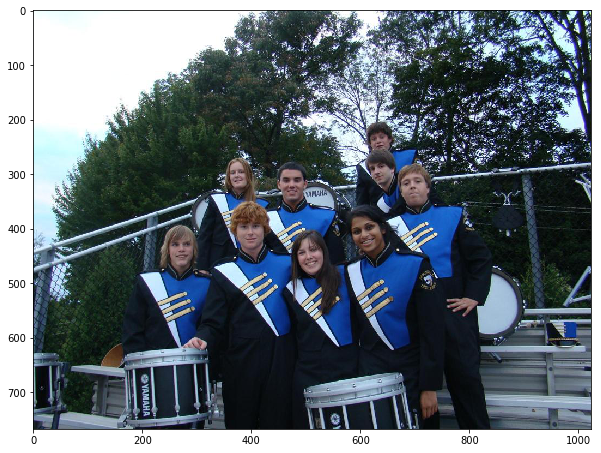

In [31]:
%matplotlib inline

img_id = 22
image = ds.pull_image(img_id)
#image = cv2.imread("selfie3.jpg")
rgb_image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)

# View the sampled input image before transform
plt.figure(figsize=(10,10))
plt.imshow(rgb_image)
plt.show()

In [41]:
x = cv2.resize(rgb_image, (300, 300)).astype(np.float32)
x -= (104.0, 117.0, 123.0)
x = x.astype(np.float32)
x = x[:, :, ::-1].copy()
#plt.imshow(x/255)
x = torch.from_numpy(x).permute(2, 0, 1)

In [42]:
net = net.cuda()

In [43]:
xx = Variable(x.unsqueeze(0))     # wrap tensor in Variable
if torch.cuda.is_available():
    xx = xx.cuda()
y = net(xx)

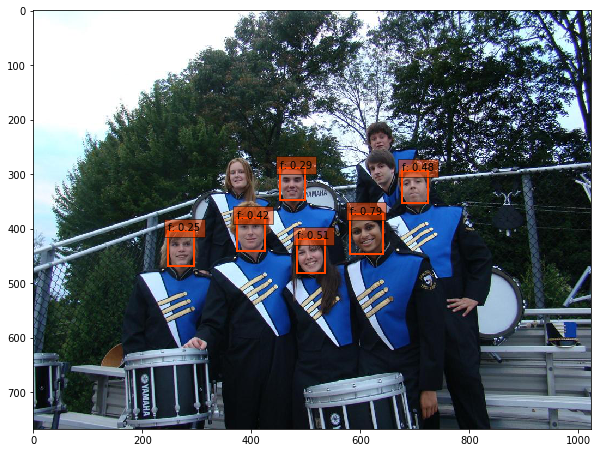

In [44]:
from data import VOC_CLASSES as labels
top_k=10

plt.figure(figsize=(10,10))
colors = plt.cm.hsv(np.linspace(0, 1, 21)).tolist()
plt.imshow(rgb_image)  # plot the image for matplotlib
currentAxis = plt.gca()

detections = y.data
# scale each detection back up to the image
scale = torch.Tensor(rgb_image.shape[1::-1]).repeat(2)
for i in range(detections.size(1)):
    j = 0
    while detections[0,i,j,0] >= 0.25:
        score = detections[0,i,j,0]
        label_name = labels[i-1]
        display_txt = '%s: %.2f'%(label_name, score)
        pt = (detections[0,i,j,1:]*scale).cpu().numpy()
        coords = (pt[0], pt[1]), pt[2]-pt[0]+1, pt[3]-pt[1]+1
        color = colors[i]
        currentAxis.add_patch(plt.Rectangle(*coords, fill=False, edgecolor=color, linewidth=2))
        currentAxis.text(pt[0], pt[1], display_txt, bbox={'facecolor':color, 'alpha':0.5})
        j+=1

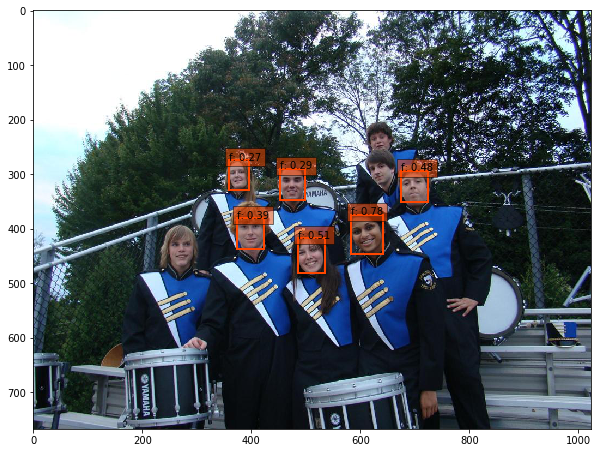

In [40]:
from data import VOC_CLASSES as labels
top_k=10

plt.figure(figsize=(10,10))
colors = plt.cm.hsv(np.linspace(0, 1, 21)).tolist()
plt.imshow(rgb_image)  # plot the image for matplotlib
currentAxis = plt.gca()

detections = y.data
# scale each detection back up to the image
scale = torch.Tensor(rgb_image.shape[1::-1]).repeat(2)
for i in range(detections.size(1)):
    j = 0
    while detections[0,i,j,0] >= 0.25:
        score = detections[0,i,j,0]
        label_name = labels[i-1]
        display_txt = '%s: %.2f'%(label_name, score)
        pt = (detections[0,i,j,1:]*scale).cpu().numpy()
        coords = (pt[0], pt[1]), pt[2]-pt[0]+1, pt[3]-pt[1]+1
        color = colors[i]
        currentAxis.add_patch(plt.Rectangle(*coords, fill=False, edgecolor=color, linewidth=2))
        currentAxis.text(pt[0], pt[1], display_txt, bbox={'facecolor':color, 'alpha':0.5})
        j+=1

In [46]:
detections.shape

torch.Size([1, 2, 200, 5])

In [52]:
boxes_and_probs = []
for i in range(detections.size(1)):
    j = 0
    while detections[0,i,j,0] >= 0.25:
        score = detections[0,i,j,0]
        pt = (detections[0,i,j,1:]*scale).cpu().numpy()
        coords = (pt[0], pt[1], pt[2]-pt[0]+1, pt[3]-pt[1]+1)
        boxes_and_probs.append((score, coords))
        j+=1

In [53]:
boxes_and_probs

[(0.7868664860725403,
  (581.3108, 373.36182, 60.1973876953125, 73.39666748046875)),
 (0.5053191781044006,
  (484.5847, 418.67548, 50.384063720703125, 62.3663330078125)),
 (0.47630348801612854,
  (675.6898, 293.7133, 47.85650634765625, 58.911651611328125)),
 (0.41792258620262146,
  (372.9611, 380.82782, 51.301055908203125, 59.625396728515625)),
 (0.29137441515922546,
  (452.4529, 289.5702, 46.404571533203125, 58.43646240234375)),
 (0.2510361969470978, (247.91837, 404.0924, 46.8291015625, 63.873291015625))]